In [1]:
# import packages
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt

In [2]:
# open the exported table (GeoJSON format) from GEE in a GeoDataFrame
fp_geojson = r"D:\jupyter notebooks\3427.10 Myanmar FewsPi\GEE training\Training december 2018\profiles_irrawady_v2.geojson"
gdf = gpd.read_file(fp_geojson)

In [3]:
# plot our sections and show the first five rows of the table
gdf.plot()
gdf.head()

,FID,dist,id,section_profile,geometry
0,42,0.43,42,"{'list': [[5060.0, 31], [5070.0, 31], [5080.0,...",LINESTRING (95.61285046534975 16.9956408015757...
1,44,0.45,44,"{'list': [[4190.0, 3], [4200.0, 3], [4210.0, 3...",LINESTRING (95.62048062445238 16.9797970006156...
2,43,0.44,43,"{'list': [[760.0, 5], [770.0, 5], [970.0, 1], ...",LINESTRING (95.60867631948776 17.0016551622801...
3,41,0.42,41,"{'list': [[920.0, 7], [930.0, 7], [940.0, 7], ...",LINESTRING (95.61307488179396 16.9973014832627...
4,40,0.41,40,"{'list': [[5050.0, 4], [5060.0, 4], [5070.0, 4...",LINESTRING (95.61473556348099 16.9901650403374...


In [4]:
gdf['section_profile'].head()

0    {'list': [[5060.0, 31], [5070.0, 31], [5080.0,...
1    {'list': [[4190.0, 3], [4200.0, 3], [4210.0, 3...
2    {'list': [[760.0, 5], [770.0, 5], [970.0, 1], ...
3    {'list': [[920.0, 7], [930.0, 7], [940.0, 7], ...
4    {'list': [[5050.0, 4], [5060.0, 4], [5070.0, 4...
Name: section_profile, dtype: object

In [5]:
# x : dist
# y : section_profile['list'][:, 0]
# z : section_profile['list'][:, 1]

In [6]:
df = pd.DataFrame()
for idx, row in gdf.iterrows():
    x = row['dist']
    
    section = np.array(row['section_profile']['list'])
    y = section[:, 0]
    z = section[:, 1]
  
    d = {'river_distance':[x] * len(y), 'section_meters':y, 'water_occurence':z}
    df_row = pd.DataFrame(d)
  
    df = df.append(df_row, ignore_index=True)
df.sort_values(by=['river_distance'], inplace=True)

In [7]:
df.head()

,river_distance,section_meters,water_occurence
13191,0.01,5910.0,42.0
13217,0.01,6190.0,98.0
13218,0.01,6210.0,98.0
13219,0.01,6220.0,98.0
13220,0.01,6230.0,98.0


In [8]:
#df.loc[:,'river_distance'] = df.river_distance.tolist()[::-1]

In [12]:
df_cl = pd.DataFrame([{"centerline": 7225}])
df_labels = pd.DataFrame({
    'section_meters': [8680, 6347],
    'river_distance': [0.31, 0.09],
    'city': ['Nyaungdon', 'Danuby']
})

In [13]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

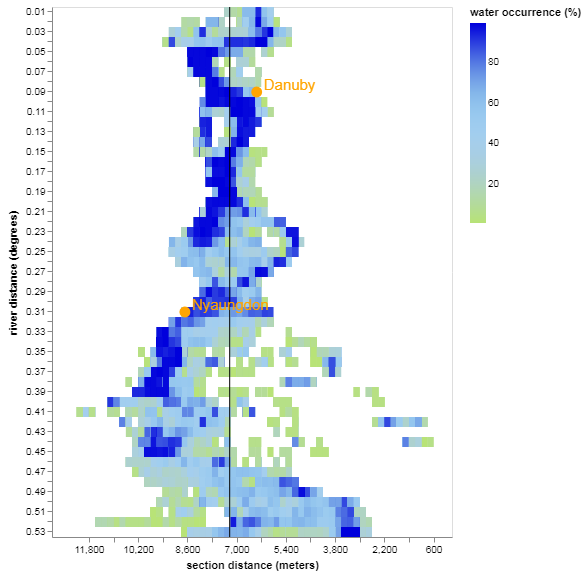

In [16]:
# create a heatmap using water occurrence
occurrence = alt.Chart(df).mark_rect().encode(
    x=alt.X('section_meters', 
            bin=alt.Bin(maxbins=100), 
            sort='descending',
            scale=alt.Scale(rangeStep=15, paddingInner=0.0), 
            title='section distance (meters)'),
    y=alt.Y('river_distance:O', 
            scale=alt.Scale(rangeStep=10, paddingInner=0.0), 
            title='river distance (degrees)'),
    color=alt.Color('water_occurence:Q', 
                    scale = alt.Scale(range=['#B8E377','#AAC7FD','#97D9E8','#0000DC']),
                    legend = alt.Legend(title='water occurrence (%)'))
)

# add the centerline of the envelope
centerline = alt.Chart(df_cl).mark_rule().encode(
    x=alt.X('centerline:Q')
)

# add the locations of the cities
citylocs = alt.Chart(df_labels).mark_point(
    filled=True, 
    color='orange',
    opacity=1).encode(
      x=alt.X('section_meters:Q'),
      y=alt.Y('river_distance:O'),
      size=alt.value(120)
)

# add the labels of the locations of the cities
citylabels = citylocs.mark_text(
    color='orange',
    align='left',
    baseline='middle',
    dx=7,
    dy=-7
).encode(
    text='city',
    size=alt.value(15)
)

occurrence + centerline + citylocs + citylabels